<a href="https://colab.research.google.com/github/LorisDiotallevi/UniversityProjects/blob/main/CRR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cox-Ross-Rubinstein (CRR) Binomial Model for Option Pricing**

## Introduction
This notebook implements the CRR binomial model to price European and American call/put options.
The model approximates the price evolution of an asset using a recombining binomial tree.
In the limiting case, as the number of time steps increases, it converges to the Black-Scholes model.
We define functions to compute:
- Up and down factors (u, d) based on CRR or Jarrow-Rudd parametrization
- Risk-neutral probability-based option pricing
- Call and put option prices using backward induction

In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Functions
def up_and_down(dT, sigma, JR=False, r=0.05):
    """
    Computes up (u) and down (d) factors for the binomial tree.
    Parameters:
    dT (float): Time step duration.
    sigma (float): Volatility of the asset.
    JR (bool): If True, use Jarrow-Rudd parametrization. If False, use CRR.
    r (float): Risk-free interest rate (used in JR parametrization).
    Returns:
    (float, float): Up (u) and down (d) factors.
    """
    if not JR:
        u = np.exp(sigma * np.sqrt(dT))  # CRR up factor
        d = np.exp(-sigma * np.sqrt(dT)) # CRR down factor
    else:
        u = np.exp((r - (sigma**2)/2) * dT + sigma * np.sqrt(dT))  # JR up factor
        d = np.exp((r - (sigma**2)/2) * dT - sigma * np.sqrt(dT))  # JR down factor
    return u, d

def opt_with_risk_neu_prob(r, d, u, dT, Vu, Vd, rate="simple"):
    """
    Computes the option price using risk-neutral probabilities.
    Parameters:
    r (float): Risk-free interest rate.
    d (float): Down factor.
    u (float): Up factor.
    dT (float): Time step duration.
    Vu (float): Option value at up node.
    Vd (float): Option value at down node.
    rate (str): Type of interest rate ("simple" or "exp").
    Returns:
    float: Risk-neutral discounted option value.
    """
    if rate == "simple":
        p = (((1 + r) ** dT) - d) / (u - d)
        return ((1 + r) ** (-dT)) * (p * Vu + (1 - p) * Vd)
    else:
        p = (np.exp(r * dT) - d) / (u - d)
        return np.exp(-r * dT) * (p * Vu + (1 - p) * Vd)

def calculate_put_option_prices(u, d, S0, K, r, N, dT, american=False, dp=5, rate="simple"):
    """
    Computes the binomial tree for put option pricing (European/American).
    """
    stock_tree = [[S0 * (u**j) * (d**(i-j)) for j in range(i+1)] for i in range(N+1)]
    final_prices = [round(max(K - price, 0), dp) for price in stock_tree[-1]]
    reverse_tree = [final_prices]

    for t in range(N):
        current_state = reverse_tree[t]
        previous_state = []
        for i in range(len(current_state) - 1):
            Vt = opt_with_risk_neu_prob(r, d, u, dT, current_state[i], current_state[i+1], rate=rate)
            if american:
                stock_value = stock_tree[-(t+2)][i]
                Vt = max(Vt, K - stock_value)
            previous_state.append(max(round(Vt, dp), 0))
        reverse_tree.append(previous_state)

    return reverse_tree

def calculate_call_option_prices(u, d, S0, K, r, N, dT, dp=5, rate="simple"):
    """
    Computes the binomial tree for call option pricing (European only).
    """
    stock_tree = [[S0 * (u**j) * (d**(i-j)) for j in range(i+1)] for i in range(N+1)]
    final_prices = [round(max(price - K, 0), dp) for price in stock_tree[-1]]
    reverse_tree = [final_prices]

    for t in range(N):
        current_state = reverse_tree[t]
        previous_state = []
        for i in range(len(current_state) - 1):
            Vt = opt_with_risk_neu_prob(r, d, u, dT, current_state[i], current_state[i+1], rate=rate)
            previous_state.append(max(round(Vt, dp), 0))
        reverse_tree.append(previous_state)

    return reverse_tree

def generate_stock_tree(up_factor, down_factor, initial_price, strike_price, risk_free_rate, periods, decimal_places=6):
    """
    Generate a binomial tree for stock prices.

    Parameters:
    up_factor (float): Upward movement factor.
    down_factor (float): Downward movement factor.
    initial_price (float): Initial stock price.
    strike_price (float): Strike price of the option.
    risk_free_rate (float): Risk-free interest rate.
    periods (int): Number of time steps.
    decimal_places (int, optional): Number of decimal places for rounding. Default is 6.

    Returns:
    list: A list of lists representing the stock price tree.
    """
    stock_tree = [[initial_price]]

    for time_step in range(periods):
        current_prices = stock_tree[time_step]
        next_prices = set()

        for price in current_prices:
            up_price = price * up_factor
            down_price = price * down_factor
            next_prices.add(round(down_price, decimal_places))
            next_prices.add(round(up_price, decimal_places))

        stock_tree.append(sorted(list(next_prices)))

    return stock_tree

def plot_stock_tree(tree, style='ko-'):
    """
    Plot a stock tree using matplotlib from a binomial tree structure.

    Parameters:
    tree (list of lists): The binary tree representing stock prices.
    style (str, optional): The style of the plot, default is 'ko-'.
    """
    stock_levels = {time_index: prices for time_index, prices in enumerate(tree)}
    stock_df = pd.DataFrame({k: pd.Series(v) for k, v in stock_levels.items()})
    reversed_stock_levels = {time_index: list(reversed(prices)) for time_index, prices in enumerate(tree)}
    reversed_stock_df = pd.DataFrame({k: pd.Series(v) for k, v in reversed_stock_levels.items()})

    plt.plot(stock_df.transpose(), style)
    plt.plot(reversed_stock_df.transpose(), style)
    plt.xlabel("Time")
    plt.ylabel("Stock Prices")
    plt.title("Stock Price Tree")

    for time_index, prices in enumerate(tree):
        for price in prices:
            plt.annotate(price, (time_index, price), textcoords="offset points", xytext=(0, -15), ha='center')

    plt.show()

def plot_option_tree(tree, option_type, style='ko-'):
    """
    Plot an option tree from a reverse-chronological binary tree.

    Parameters:
    tree (list of lists): The binary tree representing option prices.
    option_type (str): The type of option ('C' for call, otherwise put).
    style (str, optional): The style of the plot, default is 'ko-'.
    """
    option_levels = {time_index: prices for time_index, prices in enumerate(reversed(tree))}
    option_df = pd.DataFrame({k: pd.Series(v) for k, v in option_levels.items()})
    reversed_option_levels = {time_index: list(reversed(prices)) for time_index, prices in enumerate(reversed(tree))}
    reversed_option_df = pd.DataFrame({k: pd.Series(v) for k, v in reversed_option_levels.items()})

    plt.plot(option_df.transpose(), style)
    plt.plot(reversed_option_df.transpose(), style)
    plt.xlabel("Time")

    if option_type == "C":
        plt.ylabel("Call Option Prices")
        plt.title("Call Option Price Tree")
    else:
        plt.ylabel("Put Option Prices")
        plt.title("Put Option Price Tree")

    for time_index, prices in enumerate(reversed(tree)):
        for price in prices:
            plt.annotate(price, (time_index, price), textcoords="offset points", xytext=(0, -15), ha='center')

    plt.show()


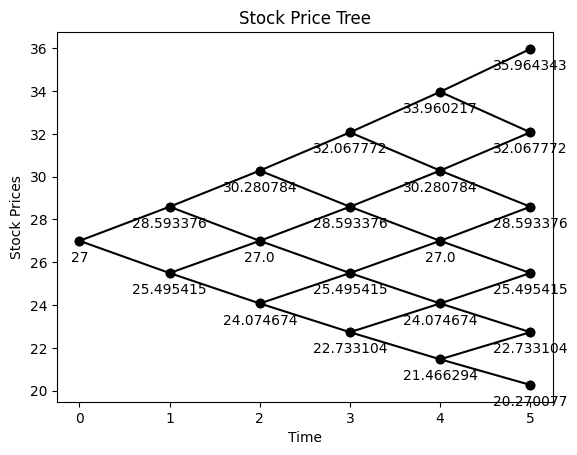



European Call value at time 0:  2.7519


European Put value at time 0:  0.486


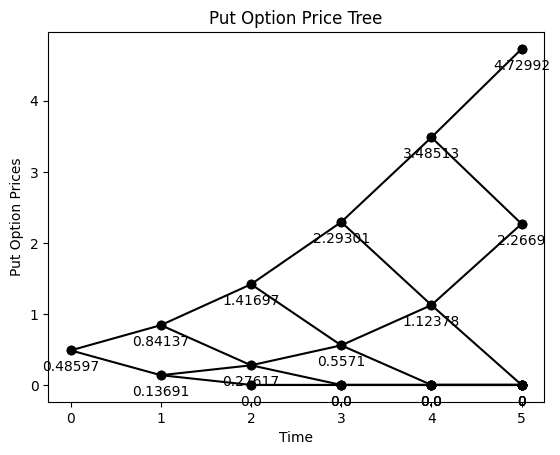

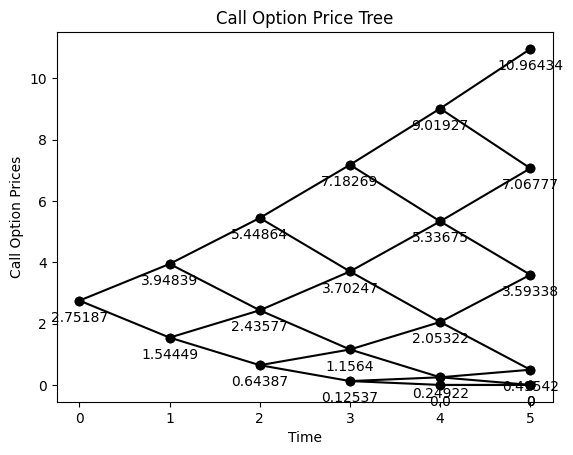



American Put value at time 0:  0.4889


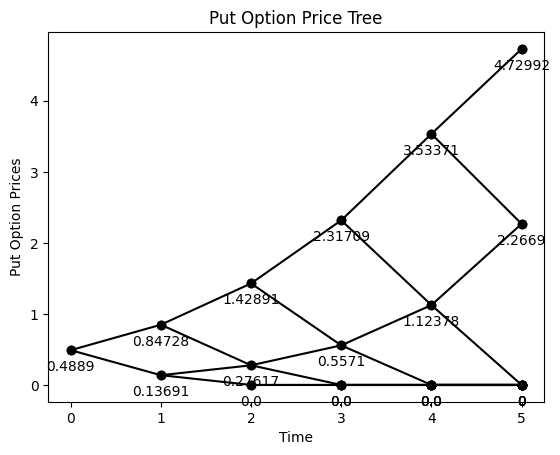

In [6]:
# Let's use the same input data that was used in class
S0 = 27  # Price of the underlying asset
K = 25  # Strike price
r = 0.015  # Risk-free interest rate
sigma = 0.2  # Volatility
T = 0.410959  # Time horizon in years
N = 5  # Number of periods in the binomial model
dT = float(T) / N  # dT is the interval of time steps

# Results with:
# 1. Cox-Ross-Rubinstein (CRR) parametrisation
# 2. Simple rate (1+r)
# This is just a check to verify if the code works well....

u, d = up_and_down(dT, sigma)
plot_stock_tree(generate_stock_tree(u, d, S0, K, r, N))
plt.show()

# Display calculated values for European call and put options
print("\n\nEuropean Call value at time 0: ", round(calculate_call_option_prices(u, d, S0, K, r, N, dT)[-1][0], 4))
print("\n\nEuropean Put value at time 0: ", round(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=False)[-1][0], 4))

# Display European put and call option tree
plot_option_tree(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=False), "P", 'ko-')
plt.show()
plot_option_tree(calculate_call_option_prices(u, d, S0, K, r, N, dT), "C")
plt.show()

# Display calculated values for American put option
print("\n\nAmerican Put value at time 0: ", round(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=True)[-1][0], 4))

# Display American put option tree
plot_option_tree(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=True), "P", 'ko-')
plt.show()

# Interpretation of results
- The first plot represents the binomial stock price tree, showing the evolution of the underlying asset over time.
- The second plot illustrates the European put option price tree, which is computed using backward induction.
- The third plot represents the European call option price tree, following the same method.
- The fourth plot shows the American put option price tree, where early exercise is considered in the valuation.
- The displayed values for call and put options at t=0 indicate their fair prices under the risk-neutral framework.


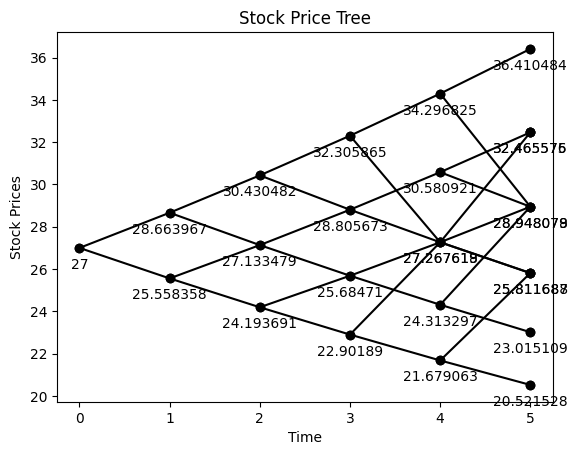



European Call value at time 0:  3.3113


European Put value at time 0:  0.371


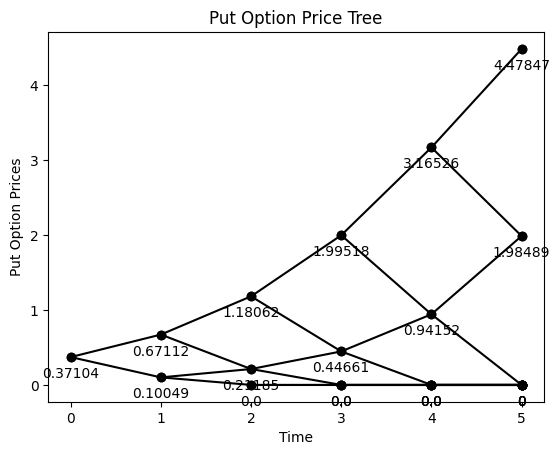

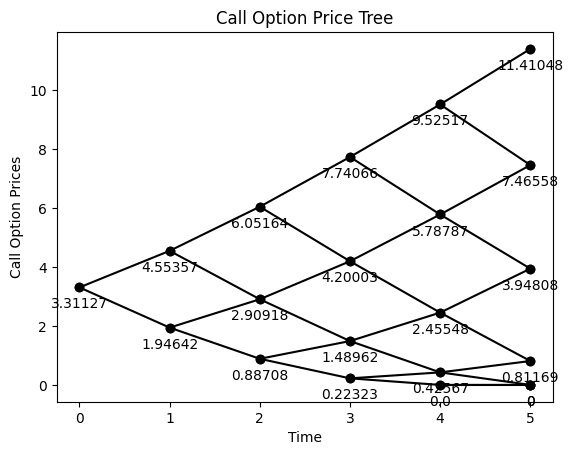



American Put value at time 0:  0.382


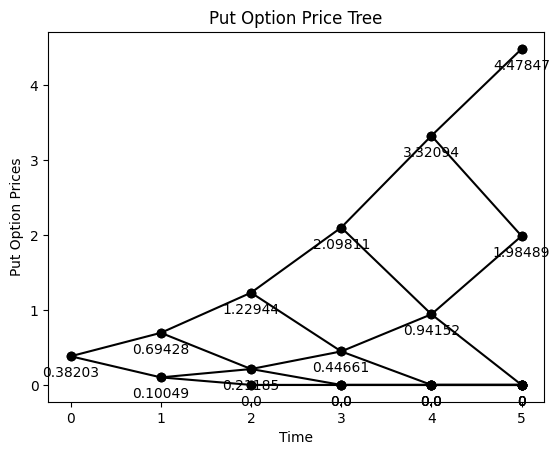

In [7]:
# Results with:
# 1. JR parametrisation for u and d
# 2. Continuously compounded rate e^r

u, d = up_and_down(dT, sigma, JR=True)
plot_stock_tree(generate_stock_tree(u, d, S0, K, r, N))
plt.show()

# Display calculated values for European call and put options
print("\n\nEuropean Call value at time 0: ", round(calculate_call_option_prices(u, d, S0, K, r, N, dT, rate="exp")[-1][0], 4))
print("\n\nEuropean Put value at time 0: ", round(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=False, rate="exp")[-1][0], 4))

# Display European put and call option tree
plot_option_tree(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=False, rate="exp"), "P", 'ko-')
plt.show()
plot_option_tree(calculate_call_option_prices(u, d, S0, K, r, N, dT, rate="exp"), "C")
plt.show()

# Display calculated values for American put option
print("\n\nAmerican Put value at time 0: ", round(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=True, rate="exp")[-1][0], 4))

# Display American put option tree
plot_option_tree(calculate_put_option_prices(u, d, S0, K, r, N, dT, american=True, rate="exp"), "P", 'ko-')
plt.show()

# Interpretation of results
- The first plot represents the binomial stock price tree under the Jarrow-Rudd parametrization.
- The second plot illustrates the European put option price tree, calculated using backward induction with continuously compounded rates.
- The third plot represents the European call option price tree, following the same methodology.
- The fourth plot shows the American put option price tree, where early exercise is considered in the valuation.
- The displayed values for call and put options at t=0 indicate their fair prices under the risk-neutral framework using continuously compounded rates.


# Conclusion

The Cox-Ross-Rubinstein (CRR) binomial model plays a fundamental role in option pricing due to its simplicity and interpretability. Unlike the Black-Scholes model, which assumes a continuous-time framework and requires solving partial differential equations, the CRR model discretizes time and constructs a recombining binomial tree. This approach makes it easier to understand and implement, particularly in real-world applications.

One of the key advantages of the CRR model is its ability to handle early exercise, making it particularly useful for pricing American-style options. Additionally, it allows for greater flexibility in incorporating different assumptions about volatility and interest rates. The step-by-step evolution of asset prices within the tree provides a clear, intuitive understanding of how options are valued under the risk-neutral framework.

Due to these advantages, the CRR model remains widely used in the financial industry, especially for pricing exotic options, employee stock options, and in educational settings where intuitive learning is crucial. Its adaptability and ease of modification continue to make it a preferred choice in many practical scenarios, solidifying its relevance alongside more complex continuous-time models.
